# Feature Extraction
The purpose of this document is to determine the subset of features from which the best model can be obtained. Specifically, we will be using feature selection to select a subset of the most relevant features. Fewer features will allow the model to be trained more efficiently and can also result in better predictive performance.

The methods of feature selection that will be investigated here include:

1. Random Forest feature importance.
2. Random Forest permutation importance.<br>
    a. Basic permutation. <br>
    b. Clustered permutation. <br>
3. Covariance matrix correlation.<br>
    a. Correlation of features with the target.<br>
    b. Correlation between features.<br>
4. Sequential feature selection.<br>
    a. Forward selection.<br>
    b. Backward elimination.<br>
5. Recursive feature elimination.

To begin, we will import the necessary libraries and load the raw summary data.


In [2]:
# Import necessary libraries and information.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SequentialFeatureSelector, RFECV, RFE
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from lib.constants import DATA_PATH

# Load batter summary data.
summary = pd.read_csv(DATA_PATH + "/Batter_Summary.txt", delimiter="\t")


## 1. Prepare the Data.
Before feature selection can occur, we must first prepare the data, including:

1. Converting categorical fields to a numerical.
2. Removing redundant fields.
3. Separating the dataset into a training and testing set.

The "Hand" field is the only categorical data in the summary dataset. By replacing Right with a zero and Left with a one, this field can be made numerical.

The Batter ID and Name fields can be removed as they are only included to identify each record. 

We will split our dataset into a training and validation set. The model will be developed using the training set and validated on the validation set. For this project, the validation set will consist of the 12 most recent One Day International batters, while the training set will be all other batsmen. This is to simulate how the model would be used in practice, where its performance is determined by how well it can predict the batting average of new One Day International batters.

In [3]:
# Replace batter hand with a numeric representation (Right Hand = 0, Left Hand = 1).
summary["Hand"] = np.where(summary["Hand"] == "Right", 0, 1)
summary = summary.drop(columns=["Name", "Batter_ID"])

# Extract features and labels.
X = summary.drop(columns=["International_One_Day_Batting_Average"])
y = summary["International_One_Day_Batting_Average"]

# Split the training and test datasets.
X_train = X[:-12]
X_test = X[-12:]
y_train = y[:-12]
y_test = y[-12:]

# Fill missing training data with the columns median.
X_train = X_train.fillna(X_train.median())


## 2. Basic Hyperparameter Tuning.
The purpose of this section is to obtain a set of reasonable hyperparameters for a simple Random Forest model. These hyperparameters are by no means optimised. Optimisation will occur in the next document, once the best features have been chosen for the model.

Here, we test combinations of several Random Forest hyperparameters, including:

1. n_estimators - Number of trees in the forest.
2. max_features - Maximum number of features considered for splitting a node.
3. max_depth - Maximum number of levels in each decision tree.
4. min_samples_split - Minimum number of data points placed in a node before the node is split.
5. min_samples_leaf - Minimum number of data points allowed in a leaf node.
6. bootstrap - Method for sampling data points (with or without replacement).

To create an approximation of reasonable hyperparameters, we will use RandomizedSearchCV. This allows us to test multiple combinations of hyperparameters without trying all possible combinations.

Below, we create a parameter grid defining the possible values that each parameter can take.

In [4]:
# Number of trees in the forest.
n_estimators = [int(x) for x in np.linspace(start=100, stop=500, num=21)]

# Number of features to consider at every split.
max_features = ["auto", "sqrt"]

# Maximum number of levels in each tree.
max_depth = [int(x) for x in np.linspace(start=10, stop=40, num=11)]
max_depth.append(None)

# Minimum number of samples required to split a node.
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node.
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree.
bootstrap = [True, False]

# Create the parameter grid.
param_grid = {"n_estimators": n_estimators,
              "max_features": max_features,
              "max_depth": max_depth,
              "min_samples_split": min_samples_split,
              "min_samples_leaf": min_samples_leaf,
              "bootstrap": bootstrap}


With the parameter grid defined, we can use RandomizedSearchCV to find a reasonable combination of parameters.

In [4]:
# Create the random forest regressor.
rfr = RandomForestRegressor()

# Create the random search cross-validator.
rfr_random = RandomizedSearchCV(
    estimator=rfr, param_distributions=param_grid, n_iter=2000, cv=3, n_jobs=-1)

# Fit the random search model.
rfr_random.fit(X_train, y_train)

# Print the best parameters for the model.
rfr_random.best_params_


{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 22,
 'bootstrap': True}

Now, we can test the accuracy of the Random Forest using the default parameters, as well as the RandomizedSearchCV parameters.

In [5]:
rfr_accuracy = 0
rfr_random_accuracy = 0
num_tests = 200

for _ in range(num_tests):
  rfr = RandomForestRegressor()
  rfr_random = RandomForestRegressor(n_estimators=100, min_samples_split=5,
                                     min_samples_leaf=4, max_features="sqrt", max_depth=22, bootstrap=True)

  rfr.fit(X_train, y_train)
  rfr_random.fit(X_train, y_train)

  rfr_accuracy += rfr.score(X_test, y_test)
  rfr_random_accuracy += rfr_random.score(X_test, y_test)

rfr_accuracy /= num_tests
rfr_random_accuracy /= num_tests

print("Model accuracy using default parameters: {}".format(rfr_accuracy))
print("Model accuracy using RandomizedSearchCV parameters: {}".format(
    rfr_random_accuracy))


Model accuracy using default parameters: 0.6814970107019538
Model accuracy using RandomizedSearchCV parameters: 0.7418600371428083


## 3. Setup.
Below, we define two functions, including:

1. A function to systematically create a RandomForestRegressor using consistent hyperparameters.
2. A function to test the average accuracy of a RandomForestRegressor.

These functions aid in simplifying code and ensuring consistency in the testing process.

In [5]:
# Function for creating the random forest regressor.
def create_random_forest_regressor():
  # Define hyperparameters.
  n_estimators = 100
  min_samples_split = 5
  min_samples_leaf = 4
  max_features = "sqrt"
  max_depth = 22
  bootstrap = True

  # Create the model.
  rfr = RandomForestRegressor(n_estimators=n_estimators, min_samples_split=min_samples_split,
                              min_samples_leaf=min_samples_leaf, max_features=max_features, max_depth=max_depth, bootstrap=bootstrap)

  # Return the model.
  return rfr


In [6]:
# Function to test the average accuracy of a model for given data.
def test_average_accuracy(X_train, X_test, y_train, y_test, num_tests=250):
  accuracy = 0

  # Train and test the model repeatedly.
  for _ in range(num_tests):
    rfr = create_random_forest_regressor()
    rfr.fit(X_train, y_train)
    accuracy += rfr.score(X_test, y_test)

  # Return the average score for the model.
  return accuracy / num_tests


## 4. Random Forests.
Random Forests provided two useful methods for determining feature importance:

1. Feature importance based on impurity.
2. Feature importance based on permutations.

We will explore both methods in their respective sections below.

### 4.1 Feature Importance Based on Decrease in Impurity.
The standard approach of measuring feature importance in a Random Forest is based on the Mean Decrease in Impurity (MDI). MDI for a feature is calculated as the sum of the number of splits that include the feature, proportionally to the number of samples it splits.

There are two main limitations of impurity-based feature importances:

1. Impurity-based feature importances are biased towards high cardinality features.
2. Impurity-based feature importances are computed on training set statistics and therefore do not reflect the ability of the feature to be useful in making predictions that generalise to the test set.

Feature importance based on impurity is explored below.

In [7]:
# Define and initialise variables.
num_tests = 1000
num_valid = 0
feature_names = X_train.columns
impurity_importances = pd.Series(0, feature_names)

# Run tests keeping track of each features importance.
for _ in range(num_tests):
    rfr = create_random_forest_regressor()
    rfr.fit(X_train, y_train)

    # Determine the feature importance for this run.
    temp_feature_importance = pd.Series(
        rfr.feature_importances_, index=feature_names)

    # Keep track of each runs feature importance.
    impurity_importances = impurity_importances.add(
        temp_feature_importance)

    # Track how many high-performing models occur.
    num_valid += 1

# Rescale and order the feature importance.
impurity_importances /= num_valid
impurity_importances = impurity_importances.sort_values(ascending=False)
impurity_importances


Domestic_Test_Average_Entering_Ball               0.067363
Domestic_Test_Average_Entering_Score              0.061917
Domestic_One_Day_Average_Ball_Count               0.058420
Domestic_One_Day_Runs_Per_Innings_Average         0.045153
Domestic_One_Day_Team_Run_Contribution_Percent    0.042735
                                                    ...   
Domestic_One_Day_Hit_Wicket_Percent               0.000000
Domestic_One_Day_Handled_Ball_Percent             0.000000
Domestic_T20_150_Rate                             0.000000
Domestic_T20_300_Rate                             0.000000
Domestic_One_Day_250_Rate                         0.000000
Length: 127, dtype: float64

We can visualise the importance of each feature in a bar graph. Due to the large number of features, we will be able to distinguish where each feature falls on the graph, however, it does give a sense of how widely dispersed the importance of each feature is. For example, we can see that the first quarter of features provides the most substantial contribution to the model's accuracy.

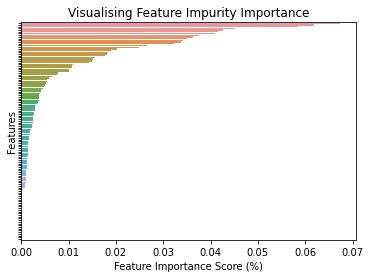

In [8]:
# Create a bar plot.
fig = plt.figure()
sns.barplot(x=impurity_importances, y=impurity_importances.index)

# Label graph.
plt.tick_params(axis="y", labelleft=False)
plt.xlabel("Feature Importance Score (%)")
plt.ylabel("Features")
plt.title("Visualising Feature Impurity Importance")
fig.patch.set_facecolor((1, 1, 1))
plt.show()


Additionally, we can visualise how the model accuracy changes when successively adding the most important features. We will sequentially add the most important features determined by the Random Forest, and observe how the model’s accuracy changes. This will allow us to see if there is a plateau in accuracy from which the feature set can be truncated.

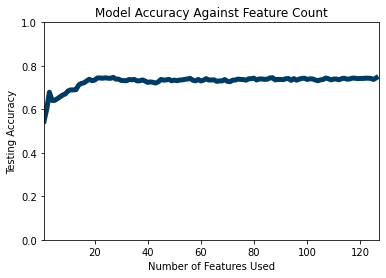

In [9]:
# Initialise an array to keep track of the accuracy for each number of features.
accuracies = []

# Determine the accuracy for each number of most important features.
for i in range(1, len(impurity_importances)):
  # Create the test and training sets for the reduced features.
  features = impurity_importances[:i].index.tolist()
  X_train_temp = X_train[features]
  X_test_temp = X_test[features]

  # Create an average accuracy.
  num_tests = 40
  accuracy = test_average_accuracy(
      X_train_temp, X_test_temp, y_train, y_test, num_tests)

  # Add the accuracy to the accuracies list.
  accuracies.append(accuracy)

# Display the accuracy.
fig = plt.figure()
plt.plot(range(1, len(impurity_importances)), accuracies, linewidth=5, color="#003b63")
plt.xlim([1, len(impurity_importances)])
plt.ylim([0, 1])
plt.xlabel("Number of Features Used")
plt.ylabel("Testing Accuracy")
plt.title("Model Accuracy Against Feature Count")
fig.patch.set_facecolor((1, 1, 1))
plt.show()


As the model's accuracy appears to plateau around 20 features, we can test how accurate the model is for the most important features based on impurity.

In [10]:
# Extract the most important feature according to permutation.
important_features_impurity = impurity_importances[:20].index.tolist()
X_train_impurity = X_train[important_features_impurity]
X_test_impurity = X_test[important_features_impurity]

# Test the accuracy of the model with reduced features.
accuracy_IFE = test_average_accuracy(
    X_train_impurity, X_test_impurity, y_train, y_test)
print("The accuracy of the model using the 20 most important impurity features is: {}".format(accuracy_IFE))


The accuracy of the model using the 20 most important impurity features is: 0.7375330246858232


### 4.2 Feature Importance Based on Feature Permutation.
Permutation importance measures feature importance by randomly permuting each feature. When permuted, features of high importance should have a greater impact on model performance than less important features. This can be used to determine feature importance.
 
Permutation importance overcomes the limitations of impurity-based feature importance: they do not have a bias toward high-cardinality features and can be computed on a left-out test set.However, the effectiveness of permutation importance can be affected by the presence of highly correlated features. For example, when two highly correlated features are present in a dataset, permuting either of the features will report low importance as the information is still accessible through its correlated feature. This will result in lower importance for both features, when they may actually be important. For this reason, we explore two types of feature permutation importance.
 
1. The importance of basic permutation (collinearity is ignored).
2. Clustered permutation importance (collinearity addressed). 

These are explored below.

#### 4.2.1 Basic Permutation Importance.
In this section, we explore the permutation importance of each feature when disregarding collinearity.

In [11]:
# Define and initialise variables.
num_tests = 1000
num_valid = 0
feature_names = X_train.columns
permutation_importances = pd.Series(0, feature_names)

# Run tests keeping track of each permutation feature importance.
for _ in range(num_tests):
    rfr = create_random_forest_regressor()
    rfr.fit(X_train, y_train)

    # Determine the feature importance for this run.
    temp_feature_importance = permutation_importance(
        rfr, X_train, y_train, n_repeats=10, n_jobs=-1)

    # Keep track of each runs feature importance.
    permutation_importances = permutation_importances.add(
        temp_feature_importance.importances_mean)

    # Track how many high-performing models occur.
    num_valid += 1

# Rescale and order the feature importance.
permutation_importances /= num_valid
permutation_importances = permutation_importances.sort_values(ascending=False)
permutation_importances


Domestic_Test_Average_Entering_Ball          0.031160
Domestic_Test_Average_Entering_Score         0.029155
Domestic_One_Day_Average_Ball_Count          0.023962
Domestic_One_Day_50_Rate                     0.018440
Domestic_One_Day_Runs_Per_Innings_Average    0.014690
                                               ...   
Domestic_Test_Handled_Ball_Percent           0.000000
Domestic_Test_Hit_Ball_Twice_Percent         0.000000
Domestic_T20_300_Rate                        0.000000
Domestic_T20_250_Rate                        0.000000
Domestic_Test_300_Rate                       0.000000
Length: 127, dtype: float64

From the above, we can conclude that permuting any feature drops the model accuracy by at most 0.0313, suggesting no features are important. However, due to the high model accuracy, we understand that some features must be important. This abnormality is likely the result of highly correlated features.

Similarly to the impurity feature importance, we can get a general sense of how important each feature is by plotting them in a bar graph.

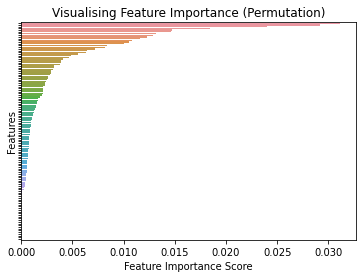

In [12]:
# Create a bar plot.
fig = plt.figure()
sns.barplot(x=permutation_importances, y=permutation_importances.index)

# Label graph.
plt.tick_params(axis="y", labelleft=False)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Visualising Feature Importance (Permutation)")
fig.patch.set_facecolor((1, 1, 1))
plt.show()


Now, we can test the model accuracy using the first 20 most important features.

In [13]:
# Extract the most important feature according to permutation.
important_features_permutation = permutation_importances[:20].index.tolist()
X_train_permutation = X_train[important_features_permutation]
X_test_permutation = X_test[important_features_permutation]

# Test the accuracy of the model with reduced features.
accuracy_PFE = test_average_accuracy(
    X_train_permutation, X_test_permutation, y_train, y_test)
print("The accuracy of the model using the 20 most important permutation features is: {}".format(accuracy_PFE))


The accuracy of the model using the 20 most important permutation features is: 0.7451720420448615


#### 4.2.2 Clustered Permuation Importance.
In this section, highly correlated features are reduced by performing hierarchical clustering on the Spearman rank-order correlations and selecting one feature from each cluster below a given threshold. It is then possible to determine the permutation importance of each feature. 

To begin, we plot a heatmap of the correlated features alongside a dendrogram. 

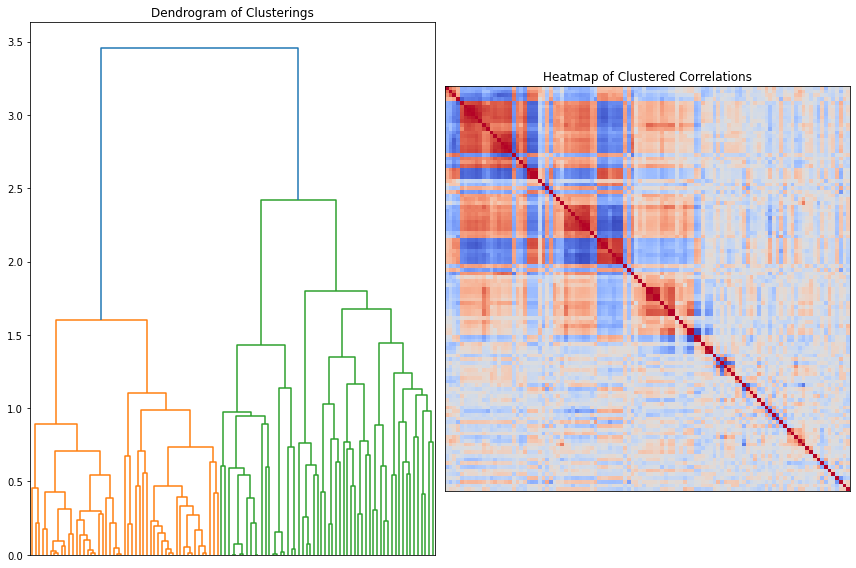

In [14]:
# Initialise the figure.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

# Remove any rows with no variance and determine correlation.
df = X_train.loc[:, (X_train != 0).any(axis=0)]
corr = spearmanr(df).correlation

# Ensure the correlation matrix is symmetric.
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# Convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))

# Plot the dendrogram.
dendro = hierarchy.dendrogram(
    dist_linkage, ax=ax1, leaf_rotation=90,
)
ax1.set_title("Dendrogram of Clusterings")
ax1.tick_params(axis="x", which='both', bottom=False,
                top=False, labelbottom=False)

# Plot the correlations in a heatmap.
ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]], cmap="coolwarm")
ax2.set_title("Heatmap of Clustered Correlations")
ax2.tick_params(axis="x", which='both', bottom=False,
                top=False, labelbottom=False)
ax2.tick_params(axis="y", which='both', left=False,
                right=False, labelleft=False)

# Display the subplots.
fig.tight_layout()
plt.show()


The dendrogram plotted above was formed by starting with each feature in its own cluster. The two most similar clusters were then combined using Ward linkage. This process was continued, reducing the number of clusters by one at each step until there was only one cluster remaining (denoted by the blue link in the above diagram). The dendrogram was used to indicate how similar clusters were based on the length of their joining link. Specifically, a shorter link signifies greater similarity than a longer link.

The heat map plotted above shows the cluster correlations. The sections with the greatest intensity along the main diagonal are indicative of clusters.

From the two plots, we can set a threshold below which clusters are selected. The threshold determines how closely related features should be in a cluster. Selecting a high threshold results in a few large clusters, while choosing a low threshold results in many smaller clusters.

Once clusters are formed, we can choose one feature from each cluster to reduce correlation. We use Sequential Feature Selection to select the optimal feature from each cluster. More details on Sequential Feature Selection will be provided later.

In [15]:
# Extract the clusters for the given threshold.
threshold = 0.25
cluster_ids = hierarchy.fcluster(dist_linkage, threshold, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)

# Initialise the selected features.
important_features_permutation = []

# Pick the best feature from each cluster using sequential feature selection.
for cluster in cluster_id_to_feature_ids.values():
    if len(cluster) == 1:
        features = X_train.iloc[:, cluster].columns.tolist()
        important_features_permutation.append(features[0])
    else:
        rfr = create_random_forest_regressor()
        selector = SequentialFeatureSelector(
            rfr, n_features_to_select=1, n_jobs=-1)
        selector = selector.fit(X_train.iloc[:, cluster], y_train)
        features = selector.get_feature_names_out(
            X_train.iloc[:, cluster].columns.tolist())
        important_features_permutation.append(features[0])

important_features_permutation


['Hand',
 'Domestic_One_Day_Innings_Count',
 'Domestic_One_Day_Win_Rate',
 'Domestic_Test_Win_Rate',
 'Domestic_T20_Innings_Count',
 'Domestic_T20_Win_Rate',
 'Domestic_One_Day_Match_Percent',
 'Domestic_Test_Match_Percent',
 'Domestic_One_Day_Caught_Percent',
 'Domestic_One_Day_Bowled_Percent',
 'Domestic_One_Day_LBW_Percent',
 'Domestic_One_Day_Hit_Wicket_Percent',
 'Domestic_One_Day_Stumped_Percent',
 'Domestic_One_Day_Run_Out_Percent',
 'Domestic_One_Day_Handled_Ball_Percent',
 'Domestic_One_Day_Hit_Ball_Twice_Percent',
 'Domestic_One_Day_Obstructed_Field_Percent',
 'Domestic_One_Day_Timed_Out_Percent',
 'Domestic_Test_Not_Out_Percent',
 'Domestic_Test_Bowled_Percent',
 'Domestic_Test_Caught_Percent',
 'Domestic_Test_150_Rate',
 'Domestic_Test_Hit_Wicket_Percent',
 'Domestic_Test_Stumped_Percent',
 'Domestic_Test_Handled_Ball_Percent',
 'Domestic_Test_Hit_Ball_Twice_Percent',
 'Domestic_Test_Obstructed_Field_Percent',
 'Domestic_T20_Not_Out_Percent',
 'Domestic_T20_Bowled_Percent',

With features selected from each cluster, we can test the average model accuracy.

In [16]:
# Extract the most important feature according to permutation.
X_train_permutation = X_train[important_features_permutation]
X_test_permutation = X_test[important_features_permutation]

# Test the accuracy of the model with reduced features.
accuracy_PFE = test_average_accuracy(
    X_train_permutation, X_test_permutation, y_train, y_test)
print("The accuracy of the model using the most important clustered permutation features is: {}".format(accuracy_PFE))


The accuracy of the model using the most important clustered permutation features is: 0.7237424393054004


## 5. Correlation Matrix - Determine the Correlation of Features.
Similarly to what was done when addressing collinearity in the permutation importance, here, we will explicitly explore correlation within the model. In particular, two types of correlation will be addressed:

1. Correlation between the target and its features
2. Feature-to-feature correlation

### 5.1 Determine the Correlation of the Target with Features.
In this section, we explore the correlation the target has with its features. In theory, the more strongly correlated a feature is with the target, the more important the feature should be in determining the model's accuracy.

Below, we plot how strongly each feature is correlated with the target.

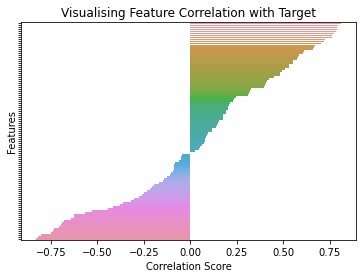

In [17]:
# Extract correlalation with the target.
data = pd.merge(left=y_train, right=X_train, left_index=True, right_index=True)
correlation = data.corr()["International_One_Day_Batting_Average"]
correlation = correlation.drop(
    "International_One_Day_Batting_Average").sort_values(ascending=False)
correlation = correlation[~correlation.isna()]

# Create a bar plot.
fig = plt.figure()
sns.barplot(x=correlation, y=correlation.index)

# Label graph.
plt.tick_params(axis="y", labelleft=False)
plt.xlabel("Correlation Score")
plt.ylabel("Features")
plt.title("Visualising Feature Correlation with Target")
fig.patch.set_facecolor((1, 1, 1))
plt.show()


Alone, this figure does not provide much insight into selecting the optimal features for the model. However, something we may try is to see how important the correlation between the features and the target is in determining feature importance.

In [18]:
# Rank the correlation importance.
cov_ranking = correlation.to_frame().copy()
cov_ranking = cov_ranking.rename(
    {cov_ranking.columns[0]: "Correlation"}, axis=1)
cov_ranking["Correlation"] = abs(cov_ranking["Correlation"])
cov_ranking = cov_ranking.sort_values(by="Correlation", ascending=False)
cov_ranking["Correlation"] = np.arange(len(cov_ranking))

# Rank the impurity importance.
imp_ranking = impurity_importances.to_frame().copy()
imp_ranking = imp_ranking[imp_ranking.index.isin(cov_ranking.index.tolist())]
imp_ranking = imp_ranking.rename(
    {imp_ranking.columns[0]: "Impurity Ranking"}, axis=1)
imp_ranking["Impurity Ranking"] = np.arange(len(imp_ranking))

# Merge correlation importance and impurity importance for comparison.
correlation_comparison = pd.merge(
    left=imp_ranking, right=cov_ranking, left_index=True, right_index=True, how="left")
correlation_comparison[:20]


,Impurity Ranking,Correlation
Domestic_Test_Average_Entering_Ball,0,0
Domestic_Test_Average_Entering_Score,1,1
Domestic_One_Day_Average_Ball_Count,2,2
Domestic_One_Day_Runs_Per_Innings_Average,3,6
Domestic_One_Day_Team_Run_Contribution_Percent,4,5
Domestic_One_Day_Runs_Per_Out_Average,5,8
Domestic_One_Day_50_Rate,6,4
Domestic_One_Day_Average_Entering_Ball,7,11
Domestic_Test_Runs_Per_Innings_Average,8,9
Domestic_Test_Team_Run_Contribution_Percent,9,7


From this, we can see that feature importance and feature correlation with the target are highly related.

### 5.2 Determine the Correlation Between Features.
While it is important to know how related the features are to the target, it is also important to know how related the features are to each other.

Highly correlated features can have detrimental effects on model performance and may reduce the accuracy of claims made about the importance of features in the model. For example, in a random forest model, if there are highly correlated features, the model can choose any of the features as an important predictor without preference for one over the other. With this feature chosen, the other features correlated with it will be assigned low importance as the impurity they are able to remove has already been removed by the chosen feature. From a model perspective, this will not reduce model accuracy. However, it could result in highly predictive features being regarded as unimportant.

Below, we explore the correlation of the features in a heatmap.

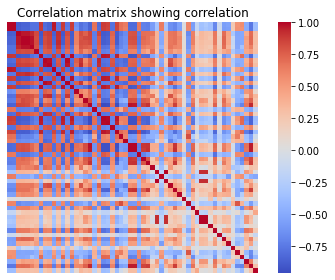

In [19]:
# Extract the correlation.
correlation = X[impurity_importances[:56].index.tolist()].corr()

# Plot the correlation matrix as a heat map.
sns.heatmap(correlation, cbar=True, square=True, cmap="coolwarm")
plt.tick_params(axis="y", which='both', left=False,
                right=False, labelleft=False)
plt.tick_params(axis="x", which='both', bottom=False,
                top=False, labelbottom=False)
plt.title("Correlation matrix showing correlation")
plt.tight_layout()
plt.show()


From the above figure, it would be possible to set a threshold to remove highly correlated features. However, it is possible for features to be highly correlated while also providing useful information. In the context of cricket, a player's batting average and the number of balls they face are highly correlated. However, these each provide useful insights into a batter that the other can't. Removing correlated features in a blunt-force method isn't recommended.

## 6. Sequential Feature Selection.
Sequential Feature Selection is a method by which features are added or removed from a model to optimise performance. This is done in a greedy fashion, where the best feature to add or remove is based on the cross-validation score.

In this section, we explore two methods:

1. Forward Sequential Feature Selection.
2. Backward Sequential Feature Elimination.

### 6.1 Forward Sequential Feature Selection.
Forward Sequential Feature Selection (SFS) is a method by which features are sequentially added to the model. First, the best single feature is selected. Then a second feature is chosen in combination with the first to produce the highest performing model. This process is continued until the desired number of features are selected.

Below, we investigate this approach.

In [20]:
# Create and train an SFS selector.
rfr = create_random_forest_regressor()
selector_SFS = SequentialFeatureSelector(
    rfr, n_features_to_select=30, n_jobs=-1)
selector_SFS = selector_SFS.fit(X_train, y_train)


With the SFS selector trained, we can determine which features are the most important.

In [21]:
# Extract the features chosen by SFS.
features_SFS = selector_SFS.get_feature_names_out(X_train.columns.tolist())
features_SFS


array(['Hand', 'Domestic_One_Day_Innings_Count',
       'Domestic_T20_Match_Count', 'Domestic_T20_Win_Rate',
       'Domestic_One_Day_Caught_Percent', 'Domestic_One_Day_LBW_Percent',
       'Domestic_One_Day_Handled_Ball_Percent',
       'Domestic_One_Day_Obstructed_Field_Percent',
       'Domestic_One_Day_Timed_Out_Percent', 'Domestic_Test_LBW_Percent',
       'Domestic_Test_Hit_Ball_Twice_Percent',
       'Domestic_T20_Not_Out_Percent', 'Domestic_T20_Bowled_Percent',
       'Domestic_T20_Hit_Ball_Twice_Percent', 'Domestic_Test_Four_Rate',
       'Domestic_T20_One_Rate', 'Domestic_T20_Two_Rate',
       'Domestic_One_Day_50_Rate', 'Domestic_One_Day_300_Rate',
       'Domestic_Test_250_Rate', 'Domestic_Test_300_Rate',
       'Domestic_T20_100_Rate', 'Domestic_T20_150_Rate',
       'Domestic_One_Day_Average_Entering_Wicket',
       'Domestic_Test_Average_Entering_Ball',
       'Domestic_One_Day_Average_Ball_Count',
       'Domestic_Test_Average_Ball_Count',
       'Domestic_Test_False_Sh

Now, we can determine the accuracy of the Random Forest model, using the reduced SFS feature set.

In [22]:
# Create a new reduced dataset from the SFS features.
X_train_SFS = X_train[features_SFS]
X_test_SFS = X_test[features_SFS]

# Print the accuracy using RFE features.
accuracy_SFS = test_average_accuracy(X_train_SFS, X_test_SFS, y_train, y_test)
print("The accuracy using features from Successive Forward Selection is: {}".format(accuracy_SFS))


The accuracy using features from Successive Forward Selection is: 0.6945457107025317


### 6.2 Backward Elimination Feature Selection.
Backward Sequential Feature Selection (SBS) is a method in which features are sequentially removed from the model. The model begins with n features, then for each subset with n-1 features, the model is tested. The n-1 features that produce the best model are retained. This is repeated for subsets n-2, n-3,... until the desired number of features remains.

Below, we investigate this approach.

In [23]:
# Create and train an SBS selector.
rfr = create_random_forest_regressor()
selector_SBS = SequentialFeatureSelector(
    rfr, direction="backward", n_features_to_select=30, n_jobs=-1)
selector_SBS = selector_SBS.fit(X_train, y_train)


With the SBS selector trained, we can determine which features are the most important.

In [24]:
# Extract the features chosen by SBS.
features_SBS = selector_SBS.get_feature_names_out(X_train.columns.tolist())
features_SBS


array(['Domestic_One_Day_Match_Count', 'Domestic_One_Day_Match_Percent',
       'Domestic_Test_Innings_Percent',
       'Domestic_One_Day_Run_Out_Percent',
       'Domestic_One_Day_Hit_Ball_Twice_Percent',
       'Domestic_Test_Bowled_Percent', 'Domestic_Test_Hit_Wicket_Percent',
       'Domestic_Test_Timed_Out_Percent',
       'Domestic_T20_Obstructed_Field_Percent',
       'Domestic_One_Day_Six_Rate',
       'Domestic_One_Day_Runs_Per_Innings_Average',
       'Domestic_Test_One_Rate', 'Domestic_Test_Four_Rate',
       'Domestic_Test_High_Score', 'Domestic_T20_Five_Rate',
       'Domestic_One_Day_50_Rate', 'Domestic_One_Day_250_Rate',
       'Domestic_One_Day_300_Rate', 'Domestic_Test_300_Rate',
       'Domestic_T20_100_Rate', 'Domestic_T20_150_Rate',
       'Domestic_T20_200_Rate', 'Domestic_T20_250_Rate',
       'Domestic_One_Day_Average_Entering_Wicket',
       'Domestic_Test_Average_Entering_Ball',
       'Domestic_Test_Average_Entering_Wicket',
       'Domestic_T20_Average_Enteri

Now, we can determine the accuracy of the Random Forest model, using the reduced SBS feature set.

In [25]:
# Create a new reduced dataset from the SBS features.
X_train_SBS = X_train[features_SBS]
X_test_SBS = X_test[features_SBS]

# Print the accuracy using RFE features.
accuracy_SBS = test_average_accuracy(X_train_SBS, X_test_SBS, y_train, y_test)
print("The accuracy using features from Successive Backward Selection is: {}".format(accuracy_SBS))


The accuracy using features from Successive Backward Selection is: 0.6880110520811772


## 7. Recursive Feature Elimination.
Recursive Feature Elimination (RFE) is a method of feature selection in which features are recursively removed until the required number of features remain. This occurs by repeatedly fitting the model and ranking its features by importance. The least important feature is then discarded.

Below, we explore the use of this technique.

In [26]:
# Create and train an RFE selector.
rfr = create_random_forest_regressor()
selector_RFE = RFECV(rfr, min_features_to_select=10, n_jobs=-1)
selector_RFE = selector_RFE.fit(X_train, y_train)


With the RFE selector trained, we can determine which features are the most important.

In [27]:
# Extract the features chosen by RFE.
features_RFE = selector_RFE.get_feature_names_out(X_train.columns.tolist())
features_RFE


array(['Domestic_One_Day_Match_Count', 'Domestic_Test_Innings_Count',
       'Domestic_T20_Not_Out_Percent', 'Domestic_One_Day_Six_Rate',
       'Domestic_One_Day_Runs_Per_Innings_Average',
       'Domestic_One_Day_Runs_Per_Out_Average',
       'Domestic_One_Day_High_Score',
       'Domestic_Test_Runs_Per_Innings_Average',
       'Domestic_Test_Runs_Per_Out_Average', 'Domestic_Test_High_Score',
       'Domestic_T20_Two_Rate', 'Domestic_T20_Four_Rate',
       'Domestic_One_Day_50_Rate', 'Domestic_Test_Start_Rate',
       'Domestic_Test_50_Rate', 'Domestic_Test_150_Rate',
       'Domestic_T20_50_Rate', 'Domestic_One_Day_Average_Entering_Ball',
       'Domestic_One_Day_Average_Entering_Score',
       'Domestic_One_Day_Average_Entering_Wicket',
       'Domestic_Test_Average_Entering_Ball',
       'Domestic_Test_Average_Entering_Score',
       'Domestic_Test_Average_Entering_Wicket',
       'Domestic_T20_Average_Entering_Score',
       'Domestic_One_Day_Average_Ball_Count',
       'Domestic

Now, we can determine the accuracy of the Random Forest model, using the reduced RFE feature set.

In [28]:
# Create a new reduced dataset from the RFE features.
X_train_RFE = X_train[features_RFE]
X_test_RFE = X_test[features_RFE]

# Print the accuracy using RFE features.
accuracy_RFE = test_average_accuracy(X_train_RFE, X_test_RFE, y_train, y_test)
print("The accuracy using features from Recursive Feature Elimination is: {}".format(accuracy_RFE))


The accuracy using features from Recursive Feature Elimination is: 0.7352280314188728


## 8. Combination of Feature Selection Techniques.
Having gained insight into the different methods of feature selection, in this section, we investigate how the methods can be combined to produce the best possible feature set. This includes several steps:

1. Elimination of redundant features
2. Exclusion of highly correlated features
3. Recursive reduction of the remaining features recursively

We will begin by removing redundant features. Some features in the summary dataset are the same for all players. These features, do not contribute any meaningful information to the model.

In [29]:
# Remove columns with no variance (this is equivalent to columns of 0's in this case).
X_train_reduced = X_train.loc[:, (X_train != 0).any(axis=0)]


Next, we will determine which features are most closely related using clustering.

In [30]:
# Determine Spearman correlation.
corr = spearmanr(X_train_reduced).correlation

# Ensure matrix is symmetric.
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# Determine cluster relatedness.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))

# Select clusters below the threshold.
threshold = 0.2
cluster_ids = hierarchy.fcluster(dist_linkage, threshold, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(X_train_reduced.columns[idx])

# Print the clusters.
cluster_id_to_feature_ids


defaultdict(list,
            {69: ['Hand'],
             32: ['Domestic_One_Day_Innings_Count',
              'Domestic_One_Day_Match_Count',
              'Domestic_Test_Innings_Count',
              'Domestic_Test_Match_Count'],
             19: ['Domestic_One_Day_Win_Rate'],
             56: ['Domestic_Test_Win_Rate'],
             33: ['Domestic_T20_Innings_Count', 'Domestic_T20_Match_Count'],
             35: ['Domestic_T20_Win_Rate'],
             41: ['Domestic_One_Day_Match_Percent',
              'Domestic_One_Day_Innings_Percent'],
             40: ['Domestic_Test_Match_Percent',
              'Domestic_T20_Match_Percent',
              'Domestic_Test_Innings_Percent',
              'Domestic_T20_Innings_Percent'],
             14: ['Domestic_One_Day_Not_Out_Percent'],
             16: ['Domestic_One_Day_Bowled_Percent'],
             15: ['Domestic_One_Day_Caught_Percent'],
             30: ['Domestic_One_Day_LBW_Percent'],
             72: ['Domestic_One_Day_Hit_Wicket_Per

In combination with cricket domain knowledge, the above list can be used to remove the least important and most highly correlated features.

In [31]:
# Remove highly correlated features from the above findings.
X_train_reduced = X_train_reduced.drop(columns=[
    "Domestic_One_Day_Innings_Count",
    "Domestic_Test_Innings_Count",
    "Domestic_T20_Innings_Count",
    "Domestic_One_Day_Innings_Percent",
    "Domestic_Test_Innings_Percent",
    "Domestic_T20_Innings_Percent",
    "Domestic_One_Day_Average_Entering_Ball",
    "Domestic_One_Day_Average_Entering_Score",
    "Domestic_Test_Average_Entering_Ball",
    "Domestic_Test_Average_Entering_Score",
    "Domestic_T20_Average_Entering_Ball",
    "Domestic_T20_Average_Entering_Score",
    "Domestic_One_Day_Runs_Per_Innings_Average",
    "Domestic_Test_Runs_Per_Innings_Average",
    "Domestic_T20_Runs_Per_Innings_Average",
])


We can now use recursive feature elimination to select the final feature set.

In [32]:
# Create a blank Random Forest Regressor.
rfr = create_random_forest_regressor()

# Use recursive feature selection to choose the best remaining features.
selector_RFE = RFE(rfr, n_features_to_select=20)
selector_RFE = selector_RFE.fit(X_train_reduced, y_train)
reduced_features = selector_RFE.get_feature_names_out(
    X_train_reduced.columns.tolist())


To test the reduced feature set, we will reconstruct our training and testing sets.

In [33]:
# Create a new reduced training and test set.
X_reduced = X[reduced_features]
X_train_reduced = X_reduced[:-12]
X_test_reduced = X_reduced[-12:]

# We must fill missing data with the columns median.
X_train_reduced = X_train_reduced.fillna(X_train_reduced.median())


Below, we print out the selected features.

In [34]:
# Print the reduced feature set.
reduced_features


array(['Domestic_One_Day_Match_Count', 'Domestic_Test_Match_Count',
       'Domestic_One_Day_Runs_Per_Out_Average',
       'Domestic_One_Day_High_Score',
       'Domestic_Test_Runs_Per_Out_Average', 'Domestic_Test_High_Score',
       'Domestic_One_Day_Start_Rate', 'Domestic_One_Day_50_Rate',
       'Domestic_Test_Start_Rate', 'Domestic_Test_50_Rate',
       'Domestic_One_Day_Average_Entering_Wicket',
       'Domestic_Test_Average_Entering_Wicket',
       'Domestic_One_Day_Average_Ball_Count',
       'Domestic_Test_Average_Ball_Count',
       'Domestic_Test_False_Shot_Rate', 'Domestic_T20_Average_Ball_Count',
       'Domestic_One_Day_Team_Run_Contribution_Percent',
       'Domestic_One_Day_Team_High_Score_Percent',
       'Domestic_Test_Team_Run_Contribution_Percent',
       'Domestic_Test_Team_High_Score_Percent'], dtype=object)

Finally, we can test the accuracy of the model using the reduced feature set.

In [35]:
# Test the accuracy of the model with reduced features.
accuracy_CFE = test_average_accuracy(
    X_train_reduced, X_test_reduced, y_train, y_test)
print("The accuracy of the model after feature selection is: {}".format(accuracy_CFE))


The accuracy of the model after feature selection is: 0.7863752047771495


### Write Reduced Summary to File.
With the features reduced, we will create a new summary dataset and save it to file for later use.

In [38]:
# Load batter summary data.
summary = pd.read_csv(DATA_PATH + "/Batter_Summary.txt", delimiter="\t")

#  Create a new dataframe of the reduced dataset.
fields = reduced_features.tolist(
) + ["Batter_ID", "Name", "International_One_Day_Batting_Average"]
summary_reduced = summary[fields]

# Write the reduced dataset to file.
summary_reduced.to_csv(
    DATA_PATH + "/Batter_Summary_Reduced.txt", sep="\t", index=False)
